In [1]:
# %% 固定壁面温度的一维稳态计算

# % 参数设置
# L = 0.24;          % 墙体的厚度，单位为米 (240mm)
# W = 1.0;           % 墙体的长度，单位为米 (1000mm)
# alpha = 2.5*10^(-6);      % 热扩散率，单位为平方米每秒
# T0 = 20;           % x=0处的温度，单位为摄氏度
# TL = 40;           % x=L处的温度，单位为摄氏度
# Ti = 25;           % 初始平均温度，单位为摄氏度

# % 计算温度分布
# x = linspace(0, L, 100); % 在墙的厚度方向生成100个点以计算温度分布
# T = T0 + (TL - T0) * (x / L); % 线性温度分布计算

In [2]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import os
# from sympy import symbols, sympify
# from scipy.special import erfc
# from kan import KAN, add_symbolic, create_dataset

# # Parameters
# alpha = 2.5e-6  # Thermal diffusivity of the soil in m^2/s
# T0 = 20        # Initial surface temperature in Celsius
# T1 = 40        # Surface temperature after change in Celsius
# L = 4          # Calculation thickness in meters
# dx = 0.1       # Spatial step in meters
# dt = 1800      # Time step in seconds
# tMax = 86400   # Simulation duration in seconds (1 day)
# W = 30         # Image width for plotting in meters

# # Time and space grid
# x = np.arange(0, L + dx, dx)  # Space grid
# t = np.arange(dt, tMax + dt, dt)  # Time grid, start from dt to avoid divide by zero

# # Initialize temperature data storage
# TemperatureData = np.zeros((len(t), len(x)))

# # Compute temperature distribution and store results
# for k in range(len(t)):
#     TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# # Normalize the data
# x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
# y_data = TemperatureData.flatten()

# x_mean = np.mean(x_data, axis=0)
# x_std = np.std(x_data, axis=0) + 1e-8  # Add small constant to avoid division by zero
# x_data_norm = (x_data - x_mean) / x_std

# y_mean = np.mean(y_data)
# y_std = np.std(y_data) + 1e-8  # Add small constant to avoid division by zero
# y_data_norm = (y_data - y_mean) / y_std

# # Convert to tensors
# x_tensor = torch.tensor(x_data_norm, dtype=torch.float32)
# y_tensor = torch.tensor(y_data_norm, dtype=torch.float32).unsqueeze(1)

# # Split dataset into training and test sets
# train_size = int(0.8 * len(x_tensor))
# test_size = len(x_tensor) - train_size
# train_input, test_input = torch.split(x_tensor, [train_size, test_size])
# train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# # Create the dataset dictionary as expected by KAN
# dataset = {
#     'train_input': train_input,
#     'train_label': train_label,
#     'test_input': test_input,
#     'test_label': test_label
# }

# # Add erfc to the symbolic library
# add_symbolic('erfc', torch.special.erfc)

# # Initialize KAN with adjusted parameters
# model = KAN(width=[2, 10, 1], grid=20, k=3, seed=0)  # Input layer now has 2 neurons

# # Plot KAN at initialization
# model(dataset['train_input'])
# model.plot(beta=100)

# # Function to train KAN with early stopping and learning rate scheduling
# def train_with_early_stopping(model, dataset, opt="LBFGS", steps=100, patience=20, initial_lr=0.0001, min_lr=1e-7, lr_decay=0.5):
#     optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
#     criterion = torch.nn.MSELoss()

#     best_loss = float('inf')
#     best_model = None
#     patience_counter = 0
#     current_lr = initial_lr

#     for step in range(steps):
#         def closure():
#             optimizer.zero_grad()
#             outputs = model(dataset['train_input'])
#             loss = criterion(outputs, dataset['train_label'])
#             loss.backward()

#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             return loss

#         loss = optimizer.step(closure).item()

#         # Validation step
#         with torch.no_grad():
#             val_outputs = model(dataset['test_input'])
#             val_loss = criterion(val_outputs, dataset['test_label']).item()

#         print(f'Step {step + 1}/{steps}, Loss: {loss}, Validation Loss: {val_loss}')

#         # Early stopping logic
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model = model.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#         # Learning rate scheduling
#         if step % patience == 0 and step > 0:
#             current_lr = max(min_lr, current_lr * lr_decay)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = current_lr

#         # Check for NaN values
#         if np.isnan(loss) or np.isnan(val_loss):
#             print("NaN detected, stopping training")
#             break

#     # Load the best model
#     if best_model is not None:
#         model.load_state_dict(best_model)

# # Train the model with early stopping and learning rate scheduling
# train_with_early_stopping(model, dataset, steps=500, patience=100, initial_lr=0.0025)

# # Plot trained KAN
# model.plot()

# # Automatically set activation functions to be symbolic
# lib = ['x', '1/sqrt(x)', 'erfc']
# model.auto_symbolic(lib=lib)

# # Prune the model
# model = model.prune()
# # # Continue training to almost machine precision with conservative settings
# # train_with_early_stopping(model, dataset, steps=200, patience=50, initial_lr=0.00001)

# # Obtain the symbolic formula in terms of normalized data
# symbolic_formula_normalized = model.symbolic_formula()[0][0]
# print("Discovered Symbolic Formula (Normalized):")
# print(symbolic_formula_normalized)

# # Reverse normalization for symbolic formula using sympy
# x_sym, t_sym = symbols('x t')
# normalized_formula = sympify(symbolic_formula_normalized)

# # Replace normalized variables with original scale variables
# original_formula = normalized_formula * (y_std / x_std[0]) + (y_mean - y_std / x_std[0] * x_mean[0])

# print("Discovered Symbolic Formula (Original):")
# print(original_formula)

# # Create output directory for plots
# outputDir = 'TemperaturePlots'
# if not os.path.exists(outputDir):
#     os.makedirs(outputDir)

# # Plot predicted temperature distribution
# x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
# x_test_norm = (x_test - x_mean) / x_std
# x_test_tensor = torch.tensor(x_test_norm, dtype=torch.float32)

# predicted_temperature = model(x_test_tensor).detach().numpy().flatten()
# predicted_temperature = predicted_temperature * y_std + y_mean  # Denormalize the prediction

# plt.figure()
# plt.plot(x, predicted_temperature, label='Predicted')
# plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
# plt.xlabel('Position along the wall thickness (m)')
# plt.ylabel('Temperature (°C)')
# plt.title('Steady-State Temperature Distribution in the Wall')
# plt.legend()
# plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
# plt.show()


In [3]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import os
# from sympy import symbols, sympify
# from scipy.special import erfc
# from kan import KAN, add_symbolic, create_dataset

# # Parameters
# alpha = 2.5e-6  # Thermal diffusivity of the soil in m^2/s
# T0 = 20        # Initial surface temperature in Celsius
# T1 = 40        # Surface temperature after change in Celsius
# L = 4          # Calculation thickness in meters
# dx = 0.1       # Spatial step in meters
# dt = 1800      # Time step in seconds
# tMax = 86400   # Simulation duration in seconds (1 day)
# W = 30         # Image width for plotting in meters

# # Time and space grid
# x = np.arange(0, L + dx, dx)  # Space grid
# t = np.arange(dt, tMax + dt, dt)  # Time grid, start from dt to avoid divide by zero

# # Initialize temperature data storage
# TemperatureData = np.zeros((len(t), len(x)))

# # Compute temperature distribution and store results
# for k in range(len(t)):
#     TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# # Prepare the data
# x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
# y_data = TemperatureData.flatten()

# # Convert to tensors
# x_tensor = torch.tensor(x_data, dtype=torch.float32)
# y_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)

# # Split dataset into training and test sets
# train_size = int(0.8 * len(x_tensor))
# test_size = len(x_tensor) - train_size
# train_input, test_input = torch.split(x_tensor, [train_size, test_size])
# train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# # Create the dataset dictionary as expected by KAN
# dataset = {
#     'train_input': train_input,
#     'train_label': train_label,
#     'test_input': test_input,
#     'test_label': test_label
# }

# # Add erfc to the symbolic library
# add_symbolic('erfc', torch.special.erfc)

# # Initialize KAN with adjusted parameters
# model = KAN(width=[2, 20, 1], grid=20, k=3, seed=0)  # Input layer now has 2 neurons

# # Plot KAN at initialization
# model(dataset['train_input'])
# model.plot(beta=100)

# # Function to train KAN with early stopping and learning rate scheduling
# def train_with_early_stopping(model, dataset, opt="LBFGS", steps=100, patience=20, initial_lr=0.0001, min_lr=1e-7, lr_decay=0.5):
#     optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
#     criterion = torch.nn.MSELoss()

#     best_loss = float('inf')
#     best_model = None
#     patience_counter = 0
#     current_lr = initial_lr

#     for step in range(steps):
#         def closure():
#             optimizer.zero_grad()
#             outputs = model(dataset['train_input'])
#             loss = criterion(outputs, dataset['train_label'])
#             loss.backward()

#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             return loss

#         loss = optimizer.step(closure).item()

#         # Validation step
#         with torch.no_grad():
#             val_outputs = model(dataset['test_input'])
#             val_loss = criterion(val_outputs, dataset['test_label']).item()

#         print(f'Step {step + 1}/{steps}, Loss: {loss}, Validation Loss: {val_loss}')

#         # Early stopping logic
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model = model.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#         # Learning rate scheduling
#         if step % patience == 0 and step > 0:
#             current_lr = max(min_lr, current_lr * lr_decay)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = current_lr

#         # Check for NaN values
#         if np.isnan(loss) or np.isnan(val_loss):
#             print("NaN detected, stopping training")
#             break

#     # Load the best model
#     if best_model is not None:
#         model.load_state_dict(best_model)

# # Train the model with early stopping and learning rate scheduling
# train_with_early_stopping(model, dataset, steps=500, patience=100, initial_lr=0.0025)

# # Plot trained KAN
# model.plot()

# # Automatically set activation functions to be symbolic
# lib = ['x', '1/sqrt(x)', 'erfc']
# model.auto_symbolic(lib=lib)

# # Prune the model
# model = model.prune()
# # # Continue training to almost machine precision with conservative settings
# # train_with_early_stopping(model, dataset, steps=200, patience=50, initial_lr=0.00001)

# # Obtain the symbolic formula
# symbolic_formula = model.symbolic_formula()[0][0]
# print("Discovered Symbolic Formula:")
# print(symbolic_formula)

# # Create output directory for plots
# outputDir = 'TemperaturePlots'
# if not os.path.exists(outputDir):
#     os.makedirs(outputDir)

# # Plot predicted temperature distribution
# x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# predicted_temperature = model(x_test_tensor).detach().numpy().flatten()

# plt.figure()
# plt.plot(x, predicted_temperature, label='Predicted')
# plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
# plt.xlabel('Position along the wall thickness (m)')
# plt.ylabel('Temperature (°C)')
# plt.title('Steady-State Temperature Distribution in the Wall')
# plt.legend()
# plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
# plt.show()


In [4]:
# import numpy as np
# import torch
# import matplotlib.pyplot as plt
# import os
# from sympy import symbols, sympify
# from scipy.special import erfc
# from kan import KAN, add_symbolic, create_dataset

# # Parameters
# alpha = 2.5e-6
# T0 = 20
# T1 = 40
# L = 4
# dx = 0.1
# dt = 1800
# tMax = 86400
# W = 30

# # Time and space grid
# x = np.arange(0, L + dx, dx)
# t = np.arange(dt, tMax + dt, dt)

# # Initialize temperature data storage
# TemperatureData = np.zeros((len(t), len(x)))

# # Compute temperature distribution and store results
# for k in range(len(t)):
#     TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# # Prepare the data
# x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
# y_data = TemperatureData.flatten()

# # Convert to tensors
# x_tensor = torch.tensor(x_data, dtype=torch.float32)
# y_tensor = torch.tensor(y_data, dtype=torch.float32).unsqueeze(1)

# # Split dataset into training and test sets
# train_size = int(0.8 * len(x_tensor))
# test_size = len(x_tensor) - train_size
# train_input, test_input = torch.split(x_tensor, [train_size, test_size])
# train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# # Create the dataset dictionary as expected by KAN
# dataset = {
#     'train_input': train_input,
#     'train_label': train_label,
#     'test_input': test_input,
#     'test_label': test_label
# }

# # Add erfc to the symbolic library
# add_symbolic('erfc', torch.special.erfc)

# # Function to train KAN with early stopping and learning rate scheduling
# def train_with_early_stopping(model, dataset, opt="LBFGS", steps=100, patience=20, initial_lr=0.0001, min_lr=1e-7, lr_decay=0.5):
#     optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
#     criterion = torch.nn.MSELoss()

#     best_loss = float('inf')
#     best_model = None
#     patience_counter = 0
#     current_lr = initial_lr

#     for step in range(steps):
#         def closure():
#             optimizer.zero_grad()
#             outputs = model(dataset['train_input'])
#             loss = criterion(outputs, dataset['train_label'])
#             loss.backward()

#             # Gradient clipping
#             torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
#             return loss

#         loss = optimizer.step(closure).item()

#         # Validation step
#         with torch.no_grad():
#             val_outputs = model(dataset['test_input'])
#             val_loss = criterion(val_outputs, dataset['test_label']).item()

#         print(f'Step {step + 1}/{steps}, Loss: {loss}, Validation Loss: {val_loss}')

#         # Early stopping logic
#         if val_loss < best_loss:
#             best_loss = val_loss
#             best_model = model.state_dict()
#             patience_counter = 0
#         else:
#             patience_counter += 1

#         if patience_counter >= patience:
#             print("Early stopping triggered")
#             break

#         # Learning rate scheduling
#         if step % patience == 0 and step > 0:
#             current_lr = max(min_lr, current_lr * lr_decay)
#             for param_group in optimizer.param_groups:
#                 param_group['lr'] = current_lr

#         # Check for NaN values
#         if np.isnan(loss) or np.isnan(val_loss):
#             print("NaN detected, stopping training")
#             break

#     # Load the best model
#     if best_model is not None:
#         model.load_state_dict(best_model)

# # Initial training with a coarse grid
# initial_grid = 3
# model = KAN(width=[2, 2, 2, 1], grid=initial_grid, k=3, seed=0)
# train_with_early_stopping(model, dataset, steps=1000, patience=100, initial_lr=0.002)

# # Iteratively refine the grid and retrain the model
# grids = [5, 10, 20, 50, 100]
# train_losses = []
# test_losses = []

# for grid in grids:
#     new_model = KAN(width=[2, 2, 2, 1], grid=grid, k=3).initialize_from_another_model(model, dataset['train_input'])
#     train_with_early_stopping(new_model, dataset, steps=500, patience=100, initial_lr=0.00005)
#     model = new_model  # Update the model to the new refined grid model

#     # Collect training and test losses
#     with torch.no_grad():
#         train_outputs = model(dataset['train_input'])
#         train_loss = torch.nn.functional.mse_loss(train_outputs, dataset['train_label']).item()
#         test_outputs = model(dataset['test_input'])
#         test_loss = torch.nn.functional.mse_loss(test_outputs, dataset['test_label']).item()
#         train_losses.append(train_loss)
#         test_losses.append(test_loss)

# # Automatically set activation functions to be symbolic
# lib = ['x', '1/sqrt(x)', 'erfc']
# model.auto_symbolic(lib=lib)

# # Prune the model
# model = model.prune()

# # Obtain the symbolic formula
# symbolic_formula = model.symbolic_formula()[0][0]
# print("Discovered Symbolic Formula:")
# print(symbolic_formula)

# # Create output directory for plots
# outputDir = 'TemperaturePlots'
# if not os.path.exists(outputDir):
#     os.makedirs(outputDir)

# # Plot predicted temperature distribution
# x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)

# predicted_temperature = model(x_test_tensor).detach().numpy().flatten()

# plt.figure()
# plt.plot(x, predicted_temperature, label='Predicted')
# plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
# plt.xlabel('Position along the wall thickness (m)')
# plt.ylabel('Temperature (°C)')
# plt.title('Steady-State Temperature Distribution in the Wall')
# plt.legend()
# plt.grid(True)
# plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
# plt.show()

# # Plot training and test losses over different grid refinements
# plt.figure()
# plt.plot(grids, train_losses, marker='o', label='Train Loss')
# plt.plot(grids, test_losses, marker='o', label='Test Loss')
# plt.xscale('log')
# plt.yscale('log')
# plt.xlabel('Grid Size')
# plt.ylabel('Loss')
# plt.legend()
# plt.grid(True)
# plt.title('Training and Test Losses over Grid Refinements')
# plt.show()


Step 1/1000, Loss: 1.006316065788269, Validation Loss: 1.371787428855896
Step 2/1000, Loss: 1.0023128986358643, Validation Loss: 1.359310269355774
Step 3/1000, Loss: 0.9985527396202087, Validation Loss: 1.3476669788360596
Step 4/1000, Loss: 0.9950290322303772, Validation Loss: 1.3368865251541138
Step 5/1000, Loss: 0.9917342066764832, Validation Loss: 1.3269546031951904
Step 6/1000, Loss: 0.9886600375175476, Validation Loss: 1.3178017139434814
Step 7/1000, Loss: 0.9857967495918274, Validation Loss: 1.3093459606170654
Step 8/1000, Loss: 0.9831345081329346, Validation Loss: 1.301518440246582
Step 9/1000, Loss: 0.9806627631187439, Validation Loss: 1.294265866279602
Step 10/1000, Loss: 0.9783706068992615, Validation Loss: 1.2875436544418335
Step 11/1000, Loss: 0.97624671459198, Validation Loss: 1.2813127040863037
Step 12/1000, Loss: 0.9742792844772339, Validation Loss: 1.2755358219146729
Step 13/1000, Loss: 0.9724573493003845, Validation Loss: 1.2701786756515503
Step 14/1000, Loss: 0.970769

Step 118/1000, Loss: 0.8852999806404114, Validation Loss: 1.1088236570358276
Step 119/1000, Loss: 0.8830040097236633, Validation Loss: 1.1058006286621094
Step 120/1000, Loss: 0.8806434869766235, Validation Loss: 1.102708101272583
Step 121/1000, Loss: 0.878217875957489, Validation Loss: 1.0995458364486694
Step 122/1000, Loss: 0.8757271766662598, Validation Loss: 1.0963135957717896
Step 123/1000, Loss: 0.8731709718704224, Validation Loss: 1.0930109024047852
Step 124/1000, Loss: 0.8705492615699768, Validation Loss: 1.0896377563476562
Step 125/1000, Loss: 0.8678617477416992, Validation Loss: 1.086193561553955
Step 126/1000, Loss: 0.8651086091995239, Validation Loss: 1.0826783180236816
Step 127/1000, Loss: 0.8622896671295166, Validation Loss: 1.079092025756836
Step 128/1000, Loss: 0.8594049215316772, Validation Loss: 1.0754340887069702
Step 129/1000, Loss: 0.856454610824585, Validation Loss: 1.0717042684555054
Step 130/1000, Loss: 0.8534388542175293, Validation Loss: 1.0679025650024414
Step

Step 231/1000, Loss: 0.43561652302742004, Validation Loss: 0.5344990491867065
Step 232/1000, Loss: 0.43340733647346497, Validation Loss: 0.5316153764724731
Step 233/1000, Loss: 0.4312133491039276, Validation Loss: 0.528746485710144
Step 234/1000, Loss: 0.4290345311164856, Validation Loss: 0.5258926153182983
Step 235/1000, Loss: 0.42687076330184937, Validation Loss: 0.5230541229248047
Step 236/1000, Loss: 0.4247218668460846, Validation Loss: 0.5202312469482422
Step 237/1000, Loss: 0.4225878119468689, Validation Loss: 0.5174242258071899
Step 238/1000, Loss: 0.4204684793949127, Validation Loss: 0.514633297920227
Step 239/1000, Loss: 0.41836366057395935, Validation Loss: 0.5118587613105774
Step 240/1000, Loss: 0.4162735044956207, Validation Loss: 0.5091007947921753
Step 241/1000, Loss: 0.4141975939273834, Validation Loss: 0.5063595175743103
Step 242/1000, Loss: 0.412136048078537, Validation Loss: 0.5036352276802063
Step 243/1000, Loss: 0.4100886285305023, Validation Loss: 0.500927984714508

Step 338/1000, Loss: 0.28790369629859924, Validation Loss: 0.3434787094593048
Step 339/1000, Loss: 0.28730908036231995, Validation Loss: 0.3427506387233734
Step 340/1000, Loss: 0.28671643137931824, Validation Loss: 0.3420255184173584
Step 341/1000, Loss: 0.2861258387565613, Validation Loss: 0.3413033187389374
Step 342/1000, Loss: 0.2855372726917267, Validation Loss: 0.3405839800834656
Step 343/1000, Loss: 0.28495073318481445, Validation Loss: 0.33986756205558777
Step 344/1000, Loss: 0.2843661606311798, Validation Loss: 0.3391540050506592
Step 345/1000, Loss: 0.28378358483314514, Validation Loss: 0.3384433090686798
Step 346/1000, Loss: 0.2832029461860657, Validation Loss: 0.33773547410964966
Step 347/1000, Loss: 0.2826242744922638, Validation Loss: 0.33703047037124634
Step 348/1000, Loss: 0.2820475697517395, Validation Loss: 0.336328387260437
Step 349/1000, Loss: 0.28147274255752563, Validation Loss: 0.33562907576560974
Step 350/1000, Loss: 0.28089988231658936, Validation Loss: 0.334932

Step 444/1000, Loss: 0.24366487562656403, Validation Loss: 0.29129037261009216
Step 445/1000, Loss: 0.24343906342983246, Validation Loss: 0.29103389382362366
Step 446/1000, Loss: 0.24321365356445312, Validation Loss: 0.29077786207199097
Step 447/1000, Loss: 0.24298857152462006, Validation Loss: 0.29052236676216125
Step 448/1000, Loss: 0.24276380240917206, Validation Loss: 0.29026737809181213
Step 449/1000, Loss: 0.2425394058227539, Validation Loss: 0.29001280665397644
Step 450/1000, Loss: 0.2423153519630432, Validation Loss: 0.2897588610649109
Step 451/1000, Loss: 0.24209162592887878, Validation Loss: 0.28950536251068115
Step 452/1000, Loss: 0.24186822772026062, Validation Loss: 0.289252370595932
Step 453/1000, Loss: 0.2416451871395111, Validation Loss: 0.28899988532066345
Step 454/1000, Loss: 0.24142244458198547, Validation Loss: 0.2887479066848755
Step 455/1000, Loss: 0.24120007455348969, Validation Loss: 0.2884964048862457
Step 456/1000, Loss: 0.24097801744937897, Validation Loss: 0

Step 551/1000, Loss: 0.22612600028514862, Validation Loss: 0.2718808054924011
Step 552/1000, Loss: 0.22602619230747223, Validation Loss: 0.27177220582962036
Step 553/1000, Loss: 0.225926473736763, Validation Loss: 0.2716638147830963
Step 554/1000, Loss: 0.22582677006721497, Validation Loss: 0.27155551314353943
Step 555/1000, Loss: 0.22572720050811768, Validation Loss: 0.2714473009109497
Step 556/1000, Loss: 0.22562766075134277, Validation Loss: 0.2713392376899719
Step 557/1000, Loss: 0.22552824020385742, Validation Loss: 0.27123120427131653
Step 558/1000, Loss: 0.22542884945869446, Validation Loss: 0.27112334966659546
Step 559/1000, Loss: 0.22532951831817627, Validation Loss: 0.2710154950618744
Step 560/1000, Loss: 0.22523029148578644, Validation Loss: 0.27090781927108765
Step 561/1000, Loss: 0.22513112425804138, Validation Loss: 0.27080029249191284
Step 562/1000, Loss: 0.2250320315361023, Validation Loss: 0.27069273591041565
Step 563/1000, Loss: 0.2249329835176468, Validation Loss: 0.

Step 657/1000, Loss: 0.21849851310253143, Validation Loss: 0.26371994614601135
Step 658/1000, Loss: 0.21845124661922455, Validation Loss: 0.26366958022117615
Step 659/1000, Loss: 0.21840399503707886, Validation Loss: 0.2636192739009857
Step 660/1000, Loss: 0.21835672855377197, Validation Loss: 0.2635689675807953
Step 661/1000, Loss: 0.21830949187278748, Validation Loss: 0.26351866126060486
Step 662/1000, Loss: 0.21826228499412537, Validation Loss: 0.2634683847427368
Step 663/1000, Loss: 0.21821506321430206, Validation Loss: 0.26341813802719116
Step 664/1000, Loss: 0.21816790103912354, Validation Loss: 0.2633679509162903
Step 665/1000, Loss: 0.2181207686662674, Validation Loss: 0.263317734003067
Step 666/1000, Loss: 0.21807359158992767, Validation Loss: 0.2632676362991333
Step 667/1000, Loss: 0.21802644431591034, Validation Loss: 0.2632174789905548
Step 668/1000, Loss: 0.2179793119430542, Validation Loss: 0.2631673514842987
Step 669/1000, Loss: 0.21793219447135925, Validation Loss: 0.26

Step 764/1000, Loss: 0.2149461805820465, Validation Loss: 0.2599772810935974
Step 765/1000, Loss: 0.21492305397987366, Validation Loss: 0.2599529027938843
Step 766/1000, Loss: 0.214899942278862, Validation Loss: 0.25992852449417114
Step 767/1000, Loss: 0.21487683057785034, Validation Loss: 0.25990408658981323
Step 768/1000, Loss: 0.21485371887683868, Validation Loss: 0.2598797082901001
Step 769/1000, Loss: 0.21483056247234344, Validation Loss: 0.2598553001880646
Step 770/1000, Loss: 0.21480749547481537, Validation Loss: 0.25983095169067383
Step 771/1000, Loss: 0.2147843837738037, Validation Loss: 0.2598065733909607
Step 772/1000, Loss: 0.21476125717163086, Validation Loss: 0.25978219509124756
Step 773/1000, Loss: 0.2147381752729416, Validation Loss: 0.2597578167915344
Step 774/1000, Loss: 0.21471509337425232, Validation Loss: 0.2597334384918213
Step 775/1000, Loss: 0.21469199657440186, Validation Loss: 0.25970908999443054
Step 776/1000, Loss: 0.2146688997745514, Validation Loss: 0.2596

Step 872/1000, Loss: 0.2132650911808014, Validation Loss: 0.2582172155380249
Step 873/1000, Loss: 0.21325361728668213, Validation Loss: 0.2582050859928131
Step 874/1000, Loss: 0.21324215829372406, Validation Loss: 0.2581930458545685
Step 875/1000, Loss: 0.2132306545972824, Validation Loss: 0.2581809461116791
Step 876/1000, Loss: 0.21321919560432434, Validation Loss: 0.25816890597343445
Step 877/1000, Loss: 0.21320775151252747, Validation Loss: 0.25815683603286743
Step 878/1000, Loss: 0.21319624781608582, Validation Loss: 0.2581447958946228
Step 879/1000, Loss: 0.21318477392196655, Validation Loss: 0.2581326961517334
Step 880/1000, Loss: 0.21317331492900848, Validation Loss: 0.258120596408844
Step 881/1000, Loss: 0.21316181123256683, Validation Loss: 0.258108526468277
Step 882/1000, Loss: 0.21315032243728638, Validation Loss: 0.25809645652770996
Step 883/1000, Loss: 0.21313883364200592, Validation Loss: 0.25808435678482056
Step 884/1000, Loss: 0.21312737464904785, Validation Loss: 0.258

Step 983/1000, Loss: 0.2124549299478531, Validation Loss: 0.2573695778846741
Step 984/1000, Loss: 0.21244916319847107, Validation Loss: 0.257363498210907
Step 985/1000, Loss: 0.21244339644908905, Validation Loss: 0.25735747814178467
Step 986/1000, Loss: 0.21243764460086823, Validation Loss: 0.2573513984680176
Step 987/1000, Loss: 0.2124318778514862, Validation Loss: 0.25734537839889526
Step 988/1000, Loss: 0.2124261111021042, Validation Loss: 0.2573392987251282
Step 989/1000, Loss: 0.21242035925388336, Validation Loss: 0.25733324885368347
Step 990/1000, Loss: 0.21241459250450134, Validation Loss: 0.2573271691799164
Step 991/1000, Loss: 0.21240882575511932, Validation Loss: 0.25732114911079407
Step 992/1000, Loss: 0.2124030739068985, Validation Loss: 0.25731509923934937
Step 993/1000, Loss: 0.21239730715751648, Validation Loss: 0.25730904936790466
Step 994/1000, Loss: 0.21239157021045685, Validation Loss: 0.25730299949645996
Step 995/1000, Loss: 0.21238580346107483, Validation Loss: 0.2

Step 91/1000, Loss: 0.2777019739151001, Validation Loss: 0.6598083972930908
Step 92/1000, Loss: 0.2773357331752777, Validation Loss: 0.6600252985954285
Step 93/1000, Loss: 0.27697086334228516, Validation Loss: 0.6602344512939453
Step 94/1000, Loss: 0.27660733461380005, Validation Loss: 0.6604369282722473
Step 95/1000, Loss: 0.27624502778053284, Validation Loss: 0.6606336236000061
Step 96/1000, Loss: 0.2758840024471283, Validation Loss: 0.6608253121376038
Step 97/1000, Loss: 0.27552419900894165, Validation Loss: 0.6610128283500671
Step 98/1000, Loss: 0.2751655578613281, Validation Loss: 0.6611967086791992
Step 99/1000, Loss: 0.2748080790042877, Validation Loss: 0.661378026008606
Step 100/1000, Loss: 0.2744518220424652, Validation Loss: 0.6615572571754456
Step 101/1000, Loss: 0.27409660816192627, Validation Loss: 0.6617351174354553
Step 102/1000, Loss: 0.27374252676963806, Validation Loss: 0.6618231534957886
Step 103/1000, Loss: 0.27356594800949097, Validation Loss: 0.6619102358818054
St

Step 89/1000, Loss: 0.9202742576599121, Validation Loss: 1.0961253643035889
Step 90/1000, Loss: 0.9185745120048523, Validation Loss: 1.094683051109314
Step 91/1000, Loss: 0.9168638586997986, Validation Loss: 1.0932271480560303
Step 92/1000, Loss: 0.9151421189308167, Validation Loss: 1.0917571783065796
Step 93/1000, Loss: 0.913409411907196, Validation Loss: 1.0902734994888306
Step 94/1000, Loss: 0.9116658568382263, Validation Loss: 1.088775634765625
Step 95/1000, Loss: 0.9099112749099731, Validation Loss: 1.087263822555542
Step 96/1000, Loss: 0.9081454873085022, Validation Loss: 1.085737943649292
Step 97/1000, Loss: 0.9063689708709717, Validation Loss: 1.0841976404190063
Step 98/1000, Loss: 0.9045811891555786, Validation Loss: 1.0826433897018433
Step 99/1000, Loss: 0.9027824997901917, Validation Loss: 1.0810747146606445
Step 100/1000, Loss: 0.9009726643562317, Validation Loss: 1.0794919729232788
Step 101/1000, Loss: 0.8991515636444092, Validation Loss: 1.0778948068618774
Step 102/1000, 

Step 200/1000, Loss: 0.7956900596618652, Validation Loss: 0.9861462712287903
Step 201/1000, Loss: 0.7944989204406738, Validation Loss: 0.9850688576698303
Step 202/1000, Loss: 0.7933042645454407, Validation Loss: 0.9845291376113892
Step 203/1000, Loss: 0.7927058339118958, Validation Loss: 0.9839891195297241
Step 204/1000, Loss: 0.7921068668365479, Validation Loss: 0.9834486246109009
Step 205/1000, Loss: 0.7915077209472656, Validation Loss: 0.982907772064209
Step 206/1000, Loss: 0.7909082174301147, Validation Loss: 0.9823666214942932
Step 207/1000, Loss: 0.79030841588974, Validation Loss: 0.9818254113197327
Step 208/1000, Loss: 0.7897083759307861, Validation Loss: 0.9812837243080139
Step 209/1000, Loss: 0.7891080975532532, Validation Loss: 0.9807419180870056
Step 210/1000, Loss: 0.7885076999664307, Validation Loss: 0.9801999926567078
Step 211/1000, Loss: 0.7879071831703186, Validation Loss: 0.979657769203186
Step 212/1000, Loss: 0.7873064279556274, Validation Loss: 0.9791153073310852
Ste

Step 309/1000, Loss: 0.7305089831352234, Validation Loss: 0.9277475476264954
Step 310/1000, Loss: 0.730201780796051, Validation Loss: 0.9274658560752869
Step 311/1000, Loss: 0.7298945188522339, Validation Loss: 0.9271841049194336
Step 312/1000, Loss: 0.7295874953269958, Validation Loss: 0.9269024133682251
Step 313/1000, Loss: 0.7292805910110474, Validation Loss: 0.9266209602355957
Step 314/1000, Loss: 0.7289738059043884, Validation Loss: 0.926339328289032
Step 315/1000, Loss: 0.728667140007019, Validation Loss: 0.9260578155517578
Step 316/1000, Loss: 0.7283605933189392, Validation Loss: 0.9257764220237732
Step 317/1000, Loss: 0.7280541658401489, Validation Loss: 0.9254951477050781
Step 318/1000, Loss: 0.7277479767799377, Validation Loss: 0.9252138137817383
Step 319/1000, Loss: 0.7274417877197266, Validation Loss: 0.9249324798583984
Step 320/1000, Loss: 0.7271358370780945, Validation Loss: 0.9246513247489929
Step 321/1000, Loss: 0.726830005645752, Validation Loss: 0.9243701696395874
Ste

Step 420/1000, Loss: 0.6996339559555054, Validation Loss: 0.8991260528564453
Step 421/1000, Loss: 0.6994845867156982, Validation Loss: 0.8989840149879456
Step 422/1000, Loss: 0.6993353962898254, Validation Loss: 0.8988419771194458
Step 423/1000, Loss: 0.6991862654685974, Validation Loss: 0.8986998200416565
Step 424/1000, Loss: 0.6990371346473694, Validation Loss: 0.8985577821731567
Step 425/1000, Loss: 0.6988880634307861, Validation Loss: 0.8984158039093018
Step 426/1000, Loss: 0.6987389922142029, Validation Loss: 0.898273766040802
Step 427/1000, Loss: 0.698590099811554, Validation Loss: 0.8981317281723022
Step 428/1000, Loss: 0.6984410285949707, Validation Loss: 0.8979896306991577
Step 429/1000, Loss: 0.6982921957969666, Validation Loss: 0.8978476524353027
Step 430/1000, Loss: 0.6981433033943176, Validation Loss: 0.8977056741714478
Step 431/1000, Loss: 0.6979945302009583, Validation Loss: 0.8975638151168823
Step 432/1000, Loss: 0.6978458166122437, Validation Loss: 0.8974217176437378
S

Step 528/1000, Loss: 0.6856210827827454, Validation Loss: 0.885701596736908
Step 529/1000, Loss: 0.6855482459068298, Validation Loss: 0.88563072681427
Step 530/1000, Loss: 0.6854753494262695, Validation Loss: 0.8855597972869873
Step 531/1000, Loss: 0.6854026317596436, Validation Loss: 0.8854889273643494
Step 532/1000, Loss: 0.6853298544883728, Validation Loss: 0.8854181170463562
Step 533/1000, Loss: 0.6852571368217468, Validation Loss: 0.8853471875190735
Step 534/1000, Loss: 0.6851843595504761, Validation Loss: 0.8852763772010803
Step 535/1000, Loss: 0.6851118206977844, Validation Loss: 0.8852054476737976
Step 536/1000, Loss: 0.6850389838218689, Validation Loss: 0.8851346373558044
Step 537/1000, Loss: 0.6849663257598877, Validation Loss: 0.8850638270378113
Step 538/1000, Loss: 0.6848936080932617, Validation Loss: 0.8849929571151733
Step 539/1000, Loss: 0.6848209500312805, Validation Loss: 0.8849221467971802
Step 540/1000, Loss: 0.6847482919692993, Validation Loss: 0.8848514556884766
St

Step 637/1000, Loss: 0.6790120005607605, Validation Loss: 0.879276692867279
Step 638/1000, Loss: 0.6789762377738953, Validation Loss: 0.8792417645454407
Step 639/1000, Loss: 0.6789404153823853, Validation Loss: 0.8792067766189575
Step 640/1000, Loss: 0.6789047718048096, Validation Loss: 0.8791716694831848
Step 641/1000, Loss: 0.6788690090179443, Validation Loss: 0.8791364431381226
Step 642/1000, Loss: 0.6788331866264343, Validation Loss: 0.8791014552116394
Step 643/1000, Loss: 0.6787973046302795, Validation Loss: 0.8790664076805115
Step 644/1000, Loss: 0.6787616014480591, Validation Loss: 0.879031240940094
Step 645/1000, Loss: 0.6787258386611938, Validation Loss: 0.8789962530136108
Step 646/1000, Loss: 0.6786900758743286, Validation Loss: 0.8789611458778381
Step 647/1000, Loss: 0.6786543130874634, Validation Loss: 0.8789262175559998
Step 648/1000, Loss: 0.6786186695098877, Validation Loss: 0.8788910508155823
Step 649/1000, Loss: 0.6785829067230225, Validation Loss: 0.8788561224937439
S

Step 747/1000, Loss: 0.6758975982666016, Validation Loss: 0.8762384653091431
Step 748/1000, Loss: 0.675879955291748, Validation Loss: 0.8762210011482239
Step 749/1000, Loss: 0.675862193107605, Validation Loss: 0.876203715801239
Step 750/1000, Loss: 0.6758446097373962, Validation Loss: 0.8761863112449646
Step 751/1000, Loss: 0.6758268475532532, Validation Loss: 0.8761690258979797
Step 752/1000, Loss: 0.6758091449737549, Validation Loss: 0.8761516213417053
Step 753/1000, Loss: 0.6757915019989014, Validation Loss: 0.8761343955993652
Step 754/1000, Loss: 0.6757738590240479, Validation Loss: 0.876116931438446
Step 755/1000, Loss: 0.6757562160491943, Validation Loss: 0.8760996460914612
Step 756/1000, Loss: 0.6757384538650513, Validation Loss: 0.8760822415351868
Step 757/1000, Loss: 0.6757208108901978, Validation Loss: 0.8760648369789124
Step 758/1000, Loss: 0.675703227519989, Validation Loss: 0.8760476112365723
Step 759/1000, Loss: 0.675685465335846, Validation Loss: 0.8760302662849426
Step 

Step 858/1000, Loss: 0.6744343042373657, Validation Loss: 0.874810516834259
Step 859/1000, Loss: 0.6744254231452942, Validation Loss: 0.8748019337654114
Step 860/1000, Loss: 0.6744167804718018, Validation Loss: 0.8747933506965637
Step 861/1000, Loss: 0.6744078993797302, Validation Loss: 0.8747847676277161
Step 862/1000, Loss: 0.6743991374969482, Validation Loss: 0.8747760653495789
Step 863/1000, Loss: 0.6743903756141663, Validation Loss: 0.8747674226760864
Step 864/1000, Loss: 0.6743817329406738, Validation Loss: 0.874758780002594
Step 865/1000, Loss: 0.6743728518486023, Validation Loss: 0.8747502565383911
Step 866/1000, Loss: 0.6743640303611755, Validation Loss: 0.8747416138648987
Step 867/1000, Loss: 0.6743553280830383, Validation Loss: 0.874733030796051
Step 868/1000, Loss: 0.6743465662002563, Validation Loss: 0.8747243881225586
Step 869/1000, Loss: 0.6743377447128296, Validation Loss: 0.8747157454490662
Step 870/1000, Loss: 0.6743290424346924, Validation Loss: 0.8747071623802185
St

Step 966/1000, Loss: 0.6737684607505798, Validation Loss: 0.8741617202758789
Step 967/1000, Loss: 0.673764169216156, Validation Loss: 0.8741573691368103
Step 968/1000, Loss: 0.6737598180770874, Validation Loss: 0.8741530776023865
Step 969/1000, Loss: 0.6737554669380188, Validation Loss: 0.8741486668586731
Step 970/1000, Loss: 0.6737511157989502, Validation Loss: 0.8741444945335388
Step 971/1000, Loss: 0.6737467050552368, Validation Loss: 0.8741402626037598
Step 972/1000, Loss: 0.6737423539161682, Validation Loss: 0.8741359710693359
Step 973/1000, Loss: 0.6737379431724548, Validation Loss: 0.8741317391395569
Step 974/1000, Loss: 0.6737335920333862, Validation Loss: 0.8741275668144226
Step 975/1000, Loss: 0.6737292408943176, Validation Loss: 0.8741230964660645
Step 976/1000, Loss: 0.673724889755249, Validation Loss: 0.8741188645362854
Step 977/1000, Loss: 0.67372065782547, Validation Loss: 0.8741145133972168
Step 978/1000, Loss: 0.673716127872467, Validation Loss: 0.8741104006767273
Step

Step 74/1000, Loss: 0.8962136507034302, Validation Loss: 1.0791144371032715
Step 75/1000, Loss: 0.8946570158004761, Validation Loss: 1.0778679847717285
Step 76/1000, Loss: 0.893100380897522, Validation Loss: 1.0766197443008423
Step 77/1000, Loss: 0.8915436267852783, Validation Loss: 1.0753694772720337
Step 78/1000, Loss: 0.8899868130683899, Validation Loss: 1.0741175413131714
Step 79/1000, Loss: 0.8884298801422119, Validation Loss: 1.0728638172149658
Step 80/1000, Loss: 0.8868727684020996, Validation Loss: 1.071608304977417
Step 81/1000, Loss: 0.8853156566619873, Validation Loss: 1.0703511238098145
Step 82/1000, Loss: 0.8837584257125854, Validation Loss: 1.0690923929214478
Step 83/1000, Loss: 0.882201075553894, Validation Loss: 1.0678319931030273
Step 84/1000, Loss: 0.8806437253952026, Validation Loss: 1.0665702819824219
Step 85/1000, Loss: 0.8790860772132874, Validation Loss: 1.0653070211410522
Step 86/1000, Loss: 0.8775282502174377, Validation Loss: 1.0640426874160767
Step 87/1000, L

Step 184/1000, Loss: 0.7873746156692505, Validation Loss: 0.9856655597686768
Step 185/1000, Loss: 0.7865370512008667, Validation Loss: 0.9847980737686157
Step 186/1000, Loss: 0.7856971025466919, Validation Loss: 0.9839258193969727
Step 187/1000, Loss: 0.7848547697067261, Validation Loss: 0.9830490350723267
Step 188/1000, Loss: 0.7840101718902588, Validation Loss: 0.9821679592132568
Step 189/1000, Loss: 0.7831629514694214, Validation Loss: 0.9812827110290527
Step 190/1000, Loss: 0.782313346862793, Validation Loss: 0.9803934693336487
Step 191/1000, Loss: 0.7814613580703735, Validation Loss: 0.9795002341270447
Step 192/1000, Loss: 0.7806066274642944, Validation Loss: 0.9786033630371094
Step 193/1000, Loss: 0.7797495722770691, Validation Loss: 0.9777029752731323
Step 194/1000, Loss: 0.7788897752761841, Validation Loss: 0.9767993688583374
Step 195/1000, Loss: 0.7780274748802185, Validation Loss: 0.9758924841880798
Step 196/1000, Loss: 0.7771627902984619, Validation Loss: 0.9749826192855835


Step 295/1000, Loss: 0.7314316630363464, Validation Loss: 0.9296121597290039
Step 296/1000, Loss: 0.7310128808021545, Validation Loss: 0.929218590259552
Step 297/1000, Loss: 0.7305946350097656, Validation Loss: 0.9288259744644165
Step 298/1000, Loss: 0.7301767468452454, Validation Loss: 0.9284342527389526
Step 299/1000, Loss: 0.7297594547271729, Validation Loss: 0.9280434846878052
Step 300/1000, Loss: 0.729342520236969, Validation Loss: 0.9276534914970398
Step 301/1000, Loss: 0.7289259433746338, Validation Loss: 0.9272644519805908
Step 302/1000, Loss: 0.7285100221633911, Validation Loss: 0.9270704388618469
Step 303/1000, Loss: 0.7283022999763489, Validation Loss: 0.9268767833709717
Step 304/1000, Loss: 0.728094756603241, Validation Loss: 0.9266835451126099
Step 305/1000, Loss: 0.7278874516487122, Validation Loss: 0.926490843296051
Step 306/1000, Loss: 0.727680504322052, Validation Loss: 0.9262984991073608
Step 307/1000, Loss: 0.7274739146232605, Validation Loss: 0.9261065721511841
Step

Step 402/1000, Loss: 0.7089233994483948, Validation Loss: 0.9092850089073181
Step 403/1000, Loss: 0.7088304162025452, Validation Loss: 0.909201979637146
Step 404/1000, Loss: 0.7087374925613403, Validation Loss: 0.9091190099716187
Step 405/1000, Loss: 0.708644688129425, Validation Loss: 0.9090362191200256
Step 406/1000, Loss: 0.7085517644882202, Validation Loss: 0.9089533686637878
Step 407/1000, Loss: 0.7084590792655945, Validation Loss: 0.9088706970214844
Step 408/1000, Loss: 0.7083665132522583, Validation Loss: 0.9087880849838257
Step 409/1000, Loss: 0.7082740068435669, Validation Loss: 0.9087055921554565
Step 410/1000, Loss: 0.7081815600395203, Validation Loss: 0.908623218536377
Step 411/1000, Loss: 0.7080891132354736, Validation Loss: 0.9085409045219421
Step 412/1000, Loss: 0.7079967856407166, Validation Loss: 0.9084587097167969
Step 413/1000, Loss: 0.707904577255249, Validation Loss: 0.9083764553070068
Step 414/1000, Loss: 0.7078124284744263, Validation Loss: 0.9082944393157959
Ste

Step 513/1000, Loss: 0.6994778513908386, Validation Loss: 0.9009473919868469
Step 514/1000, Loss: 0.699434757232666, Validation Loss: 0.900909423828125
Step 515/1000, Loss: 0.6993916034698486, Validation Loss: 0.9008714556694031
Step 516/1000, Loss: 0.6993485689163208, Validation Loss: 0.9008334875106812
Step 517/1000, Loss: 0.6993053555488586, Validation Loss: 0.9007956385612488
Step 518/1000, Loss: 0.6992623209953308, Validation Loss: 0.9007577896118164
Step 519/1000, Loss: 0.6992193460464478, Validation Loss: 0.900719940662384
Step 520/1000, Loss: 0.6991763114929199, Validation Loss: 0.9006821513175964
Step 521/1000, Loss: 0.6991333365440369, Validation Loss: 0.9006443023681641
Step 522/1000, Loss: 0.6990904808044434, Validation Loss: 0.9006065726280212
Step 523/1000, Loss: 0.6990475058555603, Validation Loss: 0.9005687832832336
Step 524/1000, Loss: 0.6990046501159668, Validation Loss: 0.9005310535430908
Step 525/1000, Loss: 0.6989615559577942, Validation Loss: 0.900493323802948
Ste

Step 624/1000, Loss: 0.6952625513076782, Validation Loss: 0.8972610831260681
Step 625/1000, Loss: 0.6952419877052307, Validation Loss: 0.8972431421279907
Step 626/1000, Loss: 0.6952213644981384, Validation Loss: 0.8972251415252686
Step 627/1000, Loss: 0.6952008008956909, Validation Loss: 0.8972070217132568
Step 628/1000, Loss: 0.6951801776885986, Validation Loss: 0.8971891403198242
Step 629/1000, Loss: 0.6951596140861511, Validation Loss: 0.8971710205078125
Step 630/1000, Loss: 0.6951391100883484, Validation Loss: 0.8971529603004456
Step 631/1000, Loss: 0.6951185464859009, Validation Loss: 0.8971350789070129
Step 632/1000, Loss: 0.6950979828834534, Validation Loss: 0.897117018699646
Step 633/1000, Loss: 0.6950775384902954, Validation Loss: 0.897098958492279
Step 634/1000, Loss: 0.6950569748878479, Validation Loss: 0.8970809578895569
Step 635/1000, Loss: 0.6950364708900452, Validation Loss: 0.8970628976821899
Step 636/1000, Loss: 0.6950159072875977, Validation Loss: 0.8970450162887573
S

Step 731/1000, Loss: 0.6933817267417908, Validation Loss: 0.8956194519996643
Step 732/1000, Loss: 0.6933717131614685, Validation Loss: 0.8956105709075928
Step 733/1000, Loss: 0.6933616995811462, Validation Loss: 0.8956018686294556
Step 734/1000, Loss: 0.693351686000824, Validation Loss: 0.8955931067466736
Step 735/1000, Loss: 0.6933416724205017, Validation Loss: 0.8955841660499573
Step 736/1000, Loss: 0.6933315396308899, Validation Loss: 0.8955753445625305
Step 737/1000, Loss: 0.6933215260505676, Validation Loss: 0.8955665826797485
Step 738/1000, Loss: 0.6933115720748901, Validation Loss: 0.8955578207969666
Step 739/1000, Loss: 0.6933014988899231, Validation Loss: 0.8955488801002502
Step 740/1000, Loss: 0.6932914853096008, Validation Loss: 0.895540177822113
Step 741/1000, Loss: 0.6932815313339233, Validation Loss: 0.8955312967300415
Step 742/1000, Loss: 0.6932715177536011, Validation Loss: 0.8955227136611938
Step 743/1000, Loss: 0.6932615041732788, Validation Loss: 0.8955137729644775
S

Step 841/1000, Loss: 0.6924808621406555, Validation Loss: 0.8948315382003784
Step 842/1000, Loss: 0.6924759745597839, Validation Loss: 0.894827127456665
Step 843/1000, Loss: 0.6924709677696228, Validation Loss: 0.8948227167129517
Step 844/1000, Loss: 0.6924660205841064, Validation Loss: 0.8948185443878174
Step 845/1000, Loss: 0.6924611330032349, Validation Loss: 0.8948141932487488
Step 846/1000, Loss: 0.6924561262130737, Validation Loss: 0.8948098421096802
Step 847/1000, Loss: 0.6924512982368469, Validation Loss: 0.8948054313659668
Step 848/1000, Loss: 0.692446231842041, Validation Loss: 0.8948010802268982
Step 849/1000, Loss: 0.6924413442611694, Validation Loss: 0.8947968482971191
Step 850/1000, Loss: 0.6924364566802979, Validation Loss: 0.8947924375534058
Step 851/1000, Loss: 0.6924315094947815, Validation Loss: 0.8947880268096924
Step 852/1000, Loss: 0.6924266219139099, Validation Loss: 0.8947837352752686
Step 853/1000, Loss: 0.6924216151237488, Validation Loss: 0.8947794437408447
S

Step 949/1000, Loss: 0.6920657753944397, Validation Loss: 0.894467294216156
Step 950/1000, Loss: 0.6920633912086487, Validation Loss: 0.8944650888442993
Step 951/1000, Loss: 0.6920608878135681, Validation Loss: 0.8944629430770874
Step 952/1000, Loss: 0.6920585036277771, Validation Loss: 0.8944608569145203
Step 953/1000, Loss: 0.6920560002326965, Validation Loss: 0.8944585919380188
Step 954/1000, Loss: 0.6920536160469055, Validation Loss: 0.8944565057754517
Step 955/1000, Loss: 0.692051112651825, Validation Loss: 0.8944542407989502
Step 956/1000, Loss: 0.6920486092567444, Validation Loss: 0.8944521546363831
Step 957/1000, Loss: 0.6920462250709534, Validation Loss: 0.8944500088691711
Step 958/1000, Loss: 0.6920438408851624, Validation Loss: 0.894447922706604
Step 959/1000, Loss: 0.6920413374900818, Validation Loss: 0.8944456577301025
Step 960/1000, Loss: 0.6920389533042908, Validation Loss: 0.8944435715675354
Step 961/1000, Loss: 0.6920364499092102, Validation Loss: 0.8944414258003235
St

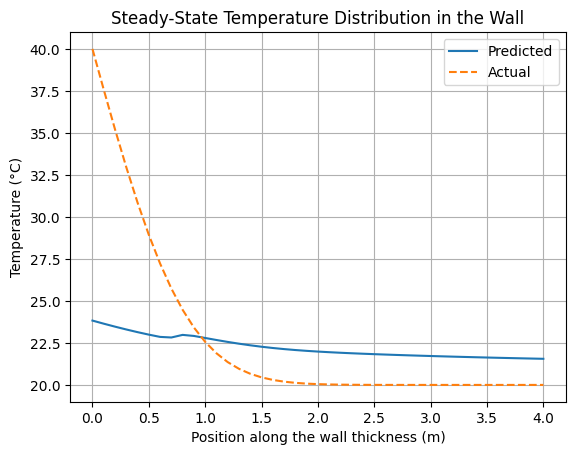

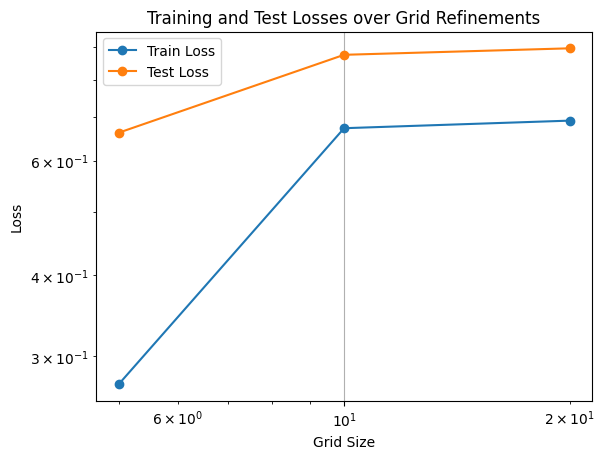

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os
from sympy import symbols, sympify
from scipy.special import erfc
from kan import KAN, add_symbolic, create_dataset

# Parameters
alpha = 2.5e-6
T0 = 20
T1 = 40
L = 4
dx = 0.1
dt = 1800
tMax = 86400
W = 30

# Time and space grid
x = np.arange(0, L + dx, dx)
t = np.arange(dt, tMax + dt, dt)

# Initialize temperature data storage
TemperatureData = np.zeros((len(t), len(x)))

# Compute temperature distribution and store results
for k in range(len(t)):
    TemperatureData[k, :] = T0 + (T1 - T0) * erfc(x / (2 * np.sqrt(alpha * t[k])))

# Prepare the data
x_data = np.array([[x_val, t_val] for t_val in t for x_val in x])
y_data = TemperatureData.flatten()

# # Normalize the data
x_mean = np.mean(x_data, axis=0)
x_std = np.std(x_data, axis=0)
y_mean = np.mean(y_data)
y_std = np.std(y_data)

x_data_normalized = (x_data - x_mean) / x_std
y_data_normalized = (y_data - y_mean) / y_std
# x_data_normalized = x_data
# y_data_normalized = y_data

# Convert to tensors
x_tensor = torch.tensor(x_data_normalized, dtype=torch.float32)
y_tensor = torch.tensor(y_data_normalized, dtype=torch.float32).unsqueeze(1)

# Split dataset into training and test sets
train_size = int(0.8 * len(x_tensor))
test_size = len(x_tensor) - train_size
train_input, test_input = torch.split(x_tensor, [train_size, test_size])
train_label, test_label = torch.split(y_tensor, [train_size, test_size])

# Create the dataset dictionary as expected by KAN
dataset = {
    'train_input': train_input,
    'train_label': train_label,
    'test_input': test_input,
    'test_label': test_label
}

# Add erfc to the symbolic library
add_symbolic('erfc', torch.special.erfc)

# Function to train KAN with early stopping and learning rate scheduling
def train_with_early_stopping(model, dataset, opt="LBFGS", steps=100, patience=20, initial_lr=0.0001, min_lr=1e-7, lr_decay=0.5):
    optimizer = torch.optim.Adam(model.parameters(), lr=initial_lr)
    criterion = torch.nn.MSELoss()

    best_loss = float('inf')
    best_model = None
    patience_counter = 0
    current_lr = initial_lr

    for step in range(steps):
        def closure():
            optimizer.zero_grad()
            outputs = model(dataset['train_input'])
            loss = criterion(outputs, dataset['train_label'])
            loss.backward()

            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            return loss

        loss = optimizer.step(closure).item()

        # Validation step
        with torch.no_grad():
            val_outputs = model(dataset['test_input'])
            val_loss = criterion(val_outputs, dataset['test_label']).item()

        print(f'Step {step + 1}/{steps}, Loss: {loss}, Validation Loss: {val_loss}')

        # Early stopping logic
        if val_loss < best_loss:
            best_loss = val_loss
            best_model = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            break

        # Learning rate scheduling
        if step % patience == 0 and step > 0:
            current_lr = max(min_lr, current_lr * lr_decay)
            for param_group in optimizer.param_groups:
                param_group['lr'] = current_lr

        # Check for NaN values
        if np.isnan(loss) or np.isnan(val_loss):
            print("NaN detected, stopping training")
            break

    # Load the best model
    if best_model is not None:
        model.load_state_dict(best_model)

# Initial training with a coarse grid
initial_grid = 3
model = KAN(width=[2, 2, 2, 1], grid=initial_grid, k=3, seed=0)
train_with_early_stopping(model, dataset, steps=1000, patience=100, initial_lr=0.002)

# Iteratively refine the grid and retrain the model
grids = [5, 10, 20]
train_losses = []
test_losses = []

for grid in grids:
    new_model = KAN(width=[2, 2, 2, 1], grid=grid, k=3).initialize_from_another_model(model, dataset['train_input'])
    train_with_early_stopping(new_model, dataset, steps=1000, patience=100, initial_lr=0.00025)
    model = new_model  # Update the model to the new refined grid model

    # Collect training and test losses
    with torch.no_grad():
        train_outputs = model(dataset['train_input'])
        train_loss = torch.nn.functional.mse_loss(train_outputs, dataset['train_label']).item()
        test_outputs = model(dataset['test_input'])
        test_loss = torch.nn.functional.mse_loss(test_outputs, dataset['test_label']).item()
        train_losses.append(train_loss)
        test_losses.append(test_loss)

# Automatically set activation functions to be symbolic
lib = ['x', '1/sqrt(x)', 'erfc']
model.auto_symbolic(lib=lib)

# Prune the model
model = model.prune()

# Obtain the symbolic formula and denormalize it
symbolic_formula = model.symbolic_formula()[0][0]
# symbolic_formula_denormalized = sympify(symbolic_formula.replace('x_1', '(x_1*{:.6f}+{:.6f})'.format(x_std[0], x_mean[0]))
#                                         .replace('x_2', '(x_2*{:.6f}+{:.6f})'.format(x_std[1], x_mean[1])))
# symbolic_formula_denormalized = (symbolic_formula_denormalized * y_std + y_mean).simplify()

# print("Discovered Symbolic Formula:")
# print(symbolic_formula_denormalized)

# Create output directory for plots
outputDir = 'TemperaturePlots'
if not os.path.exists(outputDir):
    os.makedirs(outputDir)

# Plot predicted temperature distribution
x_test = np.array([[x_val, tMax] for x_val in x])  # Use the final time step for testing
x_test_normalized = (x_test - x_mean) / x_std
x_test_tensor = torch.tensor(x_test_normalized, dtype=torch.float32)

# x_test_tensor = torch.tensor(x_test, dtype=torch.float32)


predicted_temperature = model(x_test_tensor).detach().numpy().flatten() * y_std + y_mean
# predicted_temperature = model(x_test_tensor).detach().numpy().flatten()

plt.figure()
plt.plot(x, predicted_temperature, label='Predicted')
plt.plot(x, TemperatureData[-1, :], label='Actual', linestyle='--')
plt.xlabel('Position along the wall thickness (m)')
plt.ylabel('Temperature (°C)')
plt.title('Steady-State Temperature Distribution in the Wall')
plt.legend()
plt.grid(True)
plt.savefig(f'{outputDir}/PredictedTemperatureDistribution.png', dpi=300)
plt.show()

# Plot training and test losses over different grid refinements
plt.figure()
plt.plot(grids, train_losses, marker='o', label='Train Loss')
plt.plot(grids, test_losses, marker='o', label='Test Loss')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Grid Size')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.title('Training and Test Losses over Grid Refinements')
plt.show()


In [6]:
print("Discovered Symbolic Formula (Normalized):")
model.symbolic_formula()[0][0]

Discovered Symbolic Formula (Normalized):


-0.1*erfc(-0.53*erfc(1.71*erfc(-8.74*x_1 - 9.8) + 91.92*erfc(1.45*x_2 - 0.14) - 2.78) + 76.72 - 58.59/sqrt(-0.43 + 1/sqrt(0.05*x_1 + 1))) - 0.33 + 0.13/sqrt(-0.e-2*erfc(2.52*erfc(-8.74*x_1 - 9.8) + 135.75*erfc(1.45*x_2 - 0.14) - 8.32) + 1 - 0.56/sqrt(1 - 0.64/sqrt(0.05*x_1 + 1)))

In [7]:
# print("Discovered Symbolic Formula (Original):")
# print(original_formula)